# From 2D medical image segmentation to 3D model - From AI to VR

#### Baseline model

Adapted from:
[Medical Image Segmentation Using HuggingFace & PyTorch](https://learnopencv.com/medical-image-segmentation/)  
Originated from:
[segformer-b0-finetuned-ade-512-512](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512)  

## Table of Contents


* [1 Install & Import Necessary Libraries](#1-Install-&-Import-Necessary-Libraries)
* [2 Set Hyperparameters For The Project](#2-Set-Hyperparameters-For-The-Project)
* [3 Loading The Medical Image Segmentation Dataset](#3-Loading-The-Medical-Image-Segmentation-Dataset)
    * [3.1 Defining A Custom PyTorch Dataset Class For Medical Image Segmentation](#3.1-Defining-A-Custom-PyTorch-Dataset-Class-For-Medical-Image-Segmentation)
    * [3.2 Defining The Custom LightningDataModule Class](#3.2-Defining-The-Custom-LightningDataModule-Class)
    * [3.3 Visualization Helper Functions](#3.3-Visualization-Helper-Functions)
    * [3.4 Display Sample Images From The Dataset](#3.4-Display-Sample-Images-From-The-Dataset)
* [4 Loading SegFormer From 🤗 HuggingFace](#4-Loading-SegFormer-From-🤗-HuggingFace)
* [5 Evaluation Metric & Loss Function](#5-Evaluation-Metric--&-Loss-Function)
    * [5.1 Custom Loss Functions - Smooth Dice + Cross-Entropy](#5.1-Custom-Loss-Functions---Smooth-Dice-+-Cross-Entropy)
    * [5.2 Evaluation Metric - Dice Coefficient (F1-Score)](#5.2-Evaluation-Metric---Dice-Coefficient-(F1-Score))
* [6 Creating The Custom LightningModule Class](#6-Creating-The-Custom-LightningModule-Class)
* [7 Start Training](#7-Start-Training)
* [8 Inference on the Medical Segmentation Dataset](#8-Inference-on-the-Medical-Segmentation-Dataset)
    * [8.1 Load The Best Trained Model](#8.1-Load-The-Best-Trained-Model)
    * [8.2 Evaluate Model On Validation Dataset](#8.2-Evaluate-Model-On-Validation-Dataset)
    * [8.3 Image Inference Using DataLoader Objects](#8.3-Image-Inference-Using-DataLoader-Objects)


In [1]:
"""
The command !nvidia-smi (NVIDIA System Management Interface) is a powerful utility provided by NVIDIA. 
It's used for managing and monitoring NVIDIA GPU devices. 
"""

!nvidia-smi

Sun May  5 16:48:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P4000                 WDDM  |   00000000:01:00.0  On |                  N/A |
| 55%   57C    P8              9W /  105W |    2760MiB /   8192MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1 Install & Import Necessary Libraries


1. `transformers`: To load SegFormer transformer model.
2. `lightning`: To simplify and structure code implementations.
3. `torchmetrics`: For evaluating the model's performance.
4. `wandb`: For experiment tracking. 
5. `albumentations`:  For applying augmentations. 


The transformers library is widely used for loading models such as the SegFormer transformer, which is known for its efficiency in handling image segmentation tasks. Meanwhile, lightning, specifically PyTorch Lightning, helps in structuring and simplifying code implementations, making the model development process more modular and scalable. For evaluating the performance of these models, torchmetrics provides a robust suite of metrics, enabling precise measurement of various model attributes like accuracy and precision. To keep track of experiments and model iterations, wandb (Weights & Biases) offers a comprehensive platform for logging experiments, visualizing data, and comparing different runs effectively. Lastly, albumentations is a powerful library focused on image transformations and augmentations, vital for enhancing model robustness and improving generalization by introducing variability in training data. These tools collectively facilitate a more efficient, organized, and effective approach to developing and refining deep learning models.

In [2]:
# Install libraries and restart kernel.
!pip install -qqqU wandb transformers lightning albumentations torchmetrics torchinfo
!pip install -qqq requests gradio

In [3]:
# Standard Library Imports
import os
import zipfile
import platform
import warnings
from glob import glob
from dataclasses import dataclass

# Configure warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Third-Party Library Imports for General Purpose
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

# PyTorch Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchinfo for Model Summaries
from torchinfo import summary

# Data Augmentation and Preprocessing Libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transformers Library for Model Loading
from transformers import SegformerForSemanticSegmentation

# PyTorch Lightning Framework for Simplifying Code Implementations
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Torchmetrics for Model Evaluation
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score

C:\Users\ssre_\.venv_common\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# To render the matplotlib figure in the notebook.
%matplotlib inline

For this project, instead of the default tensorboard used by pytorch-lightning for tracking experiments, we will use a proper MLOps tool: Weights & Biases (WandB). 

The following code cell will help us to log into our `wandb` account.

## Weights & Biases (W&B) 

W&B is an AI developer platform that empowers machine learning practitioners to build better models faster. Here’s how it can enhance your workflow:

Experiment Tracking: Quickly track your experiments, version datasets, and iterate on models. Evaluate model performance and reproduce results seamlessly.
Collaborative Dashboards: Visualize live metrics, datasets, logs, code, and system stats in one centralized location. Collaborate with your team to uncover critical insights.
Hyperparameter Optimization: Use W&B to perform hyperparameter sweeps and find the best model configurations.
Model Lifecycle Management: Manage your entire ML lifecycle, from training to deployment, using a unified interface. Track, version, and visualize with just a few lines of code.
Reproducibility and Debugging: Save everything in your model pipelines for debugging, provenance, and reproducibility. W&B ensures you can evaluate and deploy models with confidence.
Customer Trust: Leading ML teams worldwide trust W&B for their AI projects.

In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: sergio-sanz-rodriguez. Use `wandb login --relogin` to force relogin


True

The code cell will ask you to paste your API key in the dialogue box. You need to click on the <a href="https://wandb.ai/authorize" target="_blank">Sign In with Auth0</a> link provided.

## 2 Set Hyperparameters For The Project

Next, we will declare all the different hyperparameters used for the project. For this, we are defining three dataclasses. They will be used throughout the notebook.


1. `DatasetConfig`  – A class that holds all the hyperparameters we will use to process images. It contains the following information:
    1. Image size to use.
    2. Number of classes present in the dataset,
    3. The mean and standard deviation to use for image normalization.
    4. URL of the preprocessed dataset.
    5. Directory path to download the dataset to. 
    
2. `Paths` – This class contains the locations of the images and masks of the train and validation sets. It uses the “root dataset path”  set DatasetConfig as the base.

3. `TrainingConfig` –  A class that holds all the hyperparameters we will use for training and evaluation.  It contains the following information:
    1. Batch size.
    2. Initial learning rate.
    3. The number of epochs to train the model.
    4. The number of workers to use for data loading.
    4. Model, optimizer & learning rate scheduler-related configurations.

4. `InferenceConfig` – This class contains the (optional) batch size and the number of batches we will use to display our inference results at the end.

Note: We’ve uploaded the preprocessed dataset to our Dropbox and <a href="https://www.kaggle.com/datasets/learnopencvblog/uwm-gi-tract-segmentation-img-msk-split" target="_blank">Kaggle</a> accounts. There are two options. You can manually download the dataset and move it to your workstation or utilize the data download code we’ve written below to do it automatically.

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:   int = 4 # including background.
    IMAGE_SIZE: tuple[int,int] = (288, 288) # W, H
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD:  tuple = (0.229, 0.224, 0.225)
    BACKGROUND_CLS_ID: int = 0
    #URL: str = r"https://www.dropbox.com/scl/fi/r0685arupp33sy31qhros/dataset_UWM_GI_Tract_train_valid.zip?rlkey=w4ga9ysfiuz8vqbbywk0rdnjw&dl=1"
    DATASET_PATH: str = os.path.join(os.getcwd(), "segmentation_data")

@dataclass(frozen=True)
class Paths:
    DATA_TRAIN_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "train", "images", r"*.png")
    DATA_TRAIN_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "train", "masks",  r"*.png")
    DATA_VALID_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "valid", "images", r"*.png")
    DATA_VALID_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "valid", "masks",  r"*.png")
        
@dataclass
class TrainingConfig:
    BATCH_SIZE:      int = 16 # 48
    NUM_EPOCHS:      int = 1
    INIT_LR:       float = 3e-4
    NUM_WORKERS:     int = 0 if platform.system() == "Windows" else os.cpu_count()

    OPTIMIZER_NAME:  str = "AdamW"
    WEIGHT_DECAY:  float = 1e-4
    USE_SCHEDULER:  bool = True # Use learning rate scheduler?
    SCHEDULER:       str = "MultiStepLR" # Name of the scheduler to use.
    MODEL_NAME:str = "nvidia/segformer-b4-finetuned-ade-512-512" 
    

@dataclass
class InferenceConfig:
    BATCH_SIZE:  int = 10
    NUM_BATCHES: int = 2

## 3 Loading The Medical Image Segmentation Dataset

**Set class ID to RGB color mapping and vice versa.**

The code effectively sets up mappings that are essential for both forward operations (assigning colors to class IDs) and reverse operations (decoding colors to retrieve class IDs) in an image segmentation context.

In [7]:
# Create a mapping of class ID to RGB value.
id2color = {
    0: (0, 0, 0),    # background pixel
    1: (0, 0, 255),  # Stomach
    2: (0, 255, 0),  # Small Bowel
    3: (255, 0, 0),  # large Bowel
}


DatasetConfig.NUM_CLASSES = len(id2color)

print("Number of classes", DatasetConfig.NUM_CLASSES)

# Reverse id2color mapping.
# Used for converting RGB mask to a single channel (grayscale) representation.
rev_id2color = {value: key for key, value in id2color.items()}

Number of classes 4


### 3.1 Defining A Custom PyTorch Dataset Class For Medical Image Segmentation

First, we will define our custom PyTorch `Dataset` class. This custom is designed to load images and masks for each image. The `Dataset` class is essential for efficient and organized data handling in machine learning tasks. It provides a standardized interface to load and preprocess data samples from various sources. Encapsulating the dataset into a single object simplifies data management. It enables seamless integration with other PyTorch components like data loaders and models. 

The custom class performs the following functions:

1. Load each image-mask pair.
2. Apply geometric and pixel augmentations if the pair belongs to the training set.
3. Apply preprocessing transformations such as normalization and standardization.

In [8]:
# Custom Class for creating training and validation (segmentation) dataset objects.

class MedicalDataset(Dataset):
    def __init__(self, *, image_paths, mask_paths, img_size, ds_mean, ds_std, is_train=False):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths  
        self.is_train    = is_train
        self.img_size    = img_size
        self.ds_mean = ds_mean
        self.ds_std = ds_std
        self.transforms  = self.setup_transforms(mean=self.ds_mean, std=self.ds_std)

    def __len__(self):
        return len(self.image_paths)

    def setup_transforms(self, *, mean, std):
        transforms = []

        # Augmentation to be applied to the training set.
        if self.is_train:
            transforms.extend([
                A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(scale_limit=0.12, rotate_limit=0.15, shift_limit=0.12, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.CoarseDropout(max_holes=8, max_height=self.img_size[1]//20, max_width=self.img_size[0]//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
            ])

        # Preprocess transforms - Normalization and converting to PyTorch tensor format (HWC --> CHW).
        transforms.extend([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2(always_apply=True),  # (H, W, C) --> (C, H, W)
        ])
        return A.Compose(transforms)

    def load_file(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_NEAREST)

    def __getitem__(self, index):
        # Load image and mask file.
        image = self.load_file(self.image_paths[index], depth=cv2.IMREAD_COLOR)
        mask  = self.load_file(self.mask_paths[index],  depth=cv2.IMREAD_GRAYSCALE)
        
        # Apply Preprocessing (+ Augmentations) transformations to image-mask pair
        transformed = self.transforms(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"].to(torch.long)
        return image, mask

### 3.2 Defining The Custom LightningDataModule Class

In this section, we will define the custom `MedicalSegmentationDataModule` class inherited from Lightning’s `LightningDataModule` class. It helps organize and encapsulate all the data-related operations and logic in a PyTorch project. It acts as a bridge between your data and Lightning’s training pipeline. It is a convenient abstraction that encapsulates data-related operations, promotes code organization, and facilitates seamless integration with other Lightning components for efficient and reproducible deep-learning experiments.

The class will perform the following functions:

1. Download the dataset from Dropbox.
2. Create a MedicalDataset class object for each set.
3. Create and return the DataLoader objects for each set.


The class methods we need to define are as follows:

1. `prepare_data(..)`: This method is used for data preparation, like downloading and one-time preprocessing with the dataset. When training in a distributed setting, this will be called from each GPU machine.
2. `setup(...)`:  When you want to perform data operations on every GPU, this method is apt for it will call from every GPU. For example, perform train/val/test splits.
3. `train_dataloader(...)`: This method returns the train dataloader.
4. `val_dataloader(...)` : This method returns validation dataloader.

In [9]:
class MedicalSegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        num_classes=10,
        img_size=(384, 384),
        ds_mean=(0.485, 0.456, 0.406),
        ds_std=(0.229, 0.224, 0.225),
        batch_size=32,
        num_workers=0,
        pin_memory=False,
        shuffle_validation=False,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.img_size    = img_size
        self.ds_mean     = ds_mean
        self.ds_std      = ds_std
        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.pin_memory  = pin_memory
        
        self.shuffle_validation = shuffle_validation

    def prepare_data(self):
        # Download dataset.
        dataset_zip_path = f"{DatasetConfig.DATASET_PATH}.zip"

        # Download if dataset does not exists.
        if not os.path.exists(DatasetConfig.DATASET_PATH):

            print("Downloading and extracting assets...", end="")
            file = requests.get(DatasetConfig.URL)
            open(dataset_zip_path, "wb").write(file.content)

            try:
                with zipfile.ZipFile(dataset_zip_path) as z:
                    z.extractall(os.path.split(dataset_zip_path)[0]) # Unzip where downloaded.
                    print("Done")
            except:
                print("Invalid file")

            os.remove(dataset_zip_path) # Remove the ZIP file to free storage space.

    def setup(self, *args, **kwargs):
        # Create training dataset and dataloader.
        train_imgs = sorted(glob(f"{Paths.DATA_TRAIN_IMAGES}"))
        train_msks  = sorted(glob(f"{Paths.DATA_TRAIN_LABELS}"))

        # Create validation dataset and dataloader.
        valid_imgs = sorted(glob(f"{Paths.DATA_VALID_IMAGES}"))
        valid_msks = sorted(glob(f"{Paths.DATA_VALID_LABELS}"))

        self.train_ds = MedicalDataset(image_paths=train_imgs, mask_paths=train_msks, img_size=self.img_size,  
                                       is_train=True, ds_mean=self.ds_mean, ds_std=self.ds_std)

        self.valid_ds = MedicalDataset(image_paths=valid_imgs, mask_paths=valid_msks, img_size=self.img_size, 
                                       is_train=False, ds_mean=self.ds_mean, ds_std=self.ds_std)

    def train_dataloader(self):
        # Create train dataloader object with drop_last flag set to True.
        return DataLoader(
            self.train_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory, 
            num_workers=self.num_workers, drop_last=True, shuffle=True
        )    

    def val_dataloader(self):
        # Create validation dataloader object.
        return DataLoader(
            self.valid_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory, 
            num_workers=self.num_workers, shuffle=self.shuffle_validation
        )

**Usage**: Let's download the dataset and initialize train and validation data loaders. We’ll use them to visualize the dataset.

1. **Initialize `MedicalSegmentationDataModule`**:
   - An instance of `MedicalSegmentationDataModule` is created, named `dm`. This class appears to be a custom data module designed specifically for a medical image segmentation task. Data modules in PyTorch Lightning encapsulate the data loading logic to separate it from the model code, making the code cleaner and more modular.
   - Parameters passed to the constructor:
     - `num_classes`: The total number of target classes in the dataset.
     - `img_size`: The size to which images in the dataset should be resized or scaled.
     - `ds_mean`: The mean of the dataset, used for normalizing the data.
     - `ds_std`: The standard deviation of the dataset, also used for normalization.
     - `batch_size`: The number of samples in each batch that will be fed to the network during training or inference.
     - `num_workers`: Specifies how many sub-processes to use for data loading. `0` means that the data will be loaded in the main process. (This can slow down data loading compared to using multiple workers.)
     - `shuffle_validation`: Indicates whether the validation data should be shuffled. Shuffling can help in reducing model overfitting and making the model's performance evaluation more robust.

2. **Prepare the Data**:
   - `dm.prepare_data()`: This method is likely responsible for downloading and organizing the dataset if it's not already present locally. It sets up the dataset for later use, such as by downloading or extracting files, and is typically run once per dataset.

3. **Setup Data for Training and Validation**:
   - `dm.setup()`: This method sets up the datasets for training and validation phases. It could be splitting the dataset into training and validation sets, applying transformations, and making the data ready for use by the data loaders.

4. **Create Data Loaders for Training and Validation**:
   - `train_loader` and `valid_loader` are created by calling `dm.train_dataloader()` and `dm.val_dataloader()`. These methods return PyTorch data loaders that are used to iterate over the training and validation datasets, respectively. Data loaders handle the process of loading data in batches, applying any specified transformations, and providing the data in a form suitable for training the model.

In [10]:
%%time

dm = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size=InferenceConfig.BATCH_SIZE,
    num_workers=0,
    shuffle_validation=True,
)

# Donwload dataset.
dm.prepare_data()

# Create training & validation dataset.
dm.setup()

train_loader, valid_loader = dm.train_dataloader(), dm.val_dataloader()

CPU times: total: 125 ms
Wall time: 132 ms


### 3.3 Visualization Helper Functions

To help visualize our dataset, we need to define some additional helper functions. They are as follows:

A) `num_to_rgb(...)`: Function will be used to convert single-channel mask representations to an integrated RGB mask for visualization purposes

In [11]:
def num_to_rgb(num_arr, color_map=id2color):
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
 
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
 
    # return a floating point array in range [0.0, 1.0]
    return np.float32(output) / 255.0

B) `image_overlay(...)`: This function overlays an RGB segmentation map on top of an RGB image.

In [12]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

C) `display_image_and_mask(...)`: The convenience function below will display the original image, the ground truth mask, and the ground truth mask overlayed on the original image.

In [13]:
def display_image_and_mask(*, images, masks, color_map=id2color):
    title = ["GT Image", "Color Mask", "Overlayed Mask"]

    for idx in range(images.shape[0]):
        image = images[idx]
        grayscale_gt_mask = masks[idx]

        fig = plt.figure(figsize=(15, 4))

        # Create RGB segmentation map from grayscale segmentation map.
        rgb_gt_mask = num_to_rgb(grayscale_gt_mask, color_map=color_map)

        # Create the overlayed image.
        overlayed_image = image_overlay(image, rgb_gt_mask)

        plt.subplot(1, 3, 1)
        plt.title(title[0])
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(title[1])
        plt.imshow(rgb_gt_mask)
        plt.axis("off")

        plt.imshow(rgb_gt_mask)
        plt.subplot(1, 3, 3)
        plt.title(title[2])
        plt.imshow(overlayed_image)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return

D) `denormalize(...)`: This function is used to denormalize the image tensors and clip values between `0` and `1`. It is used to denormalize the images for visualization.

In [14]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

### 3.4 Display Sample Images From The Dataset

In the code cell below, we loop over the first batch in the validation dataset and display the ground truth image, ground truth mask, and the ground truth mask overlayed on the image. The overlay helps us better visualize the segmented classes in the context of the original image.

batch_images shape: (10, 288, 288, 3)
batch_masks shape:  (10, 288, 288)


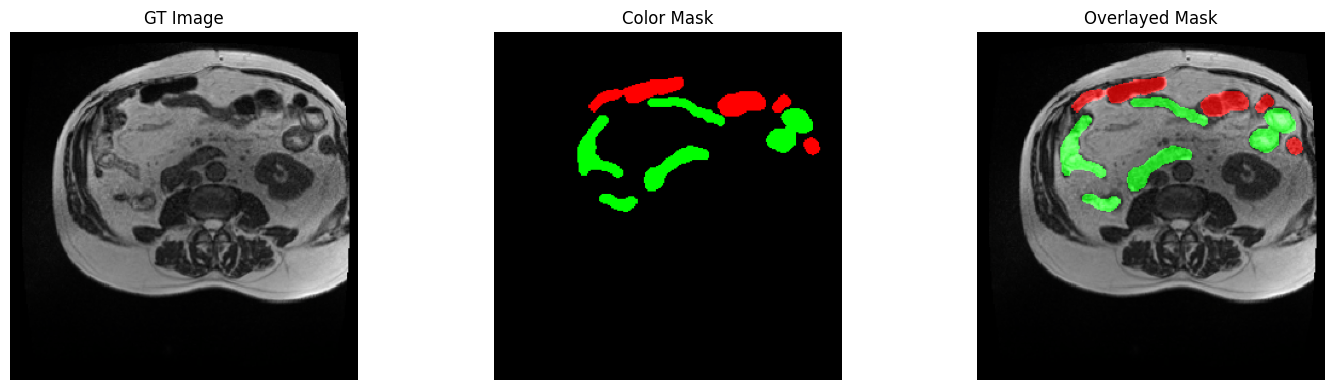

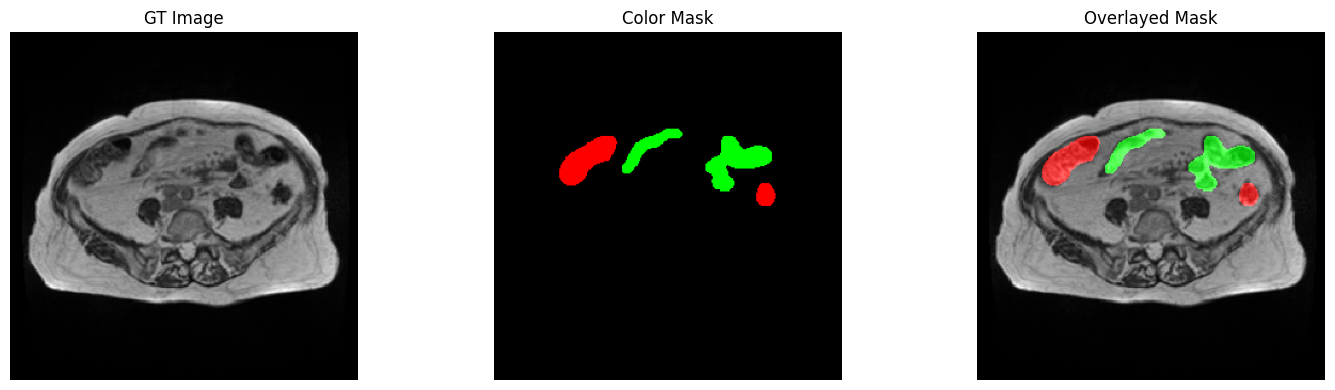

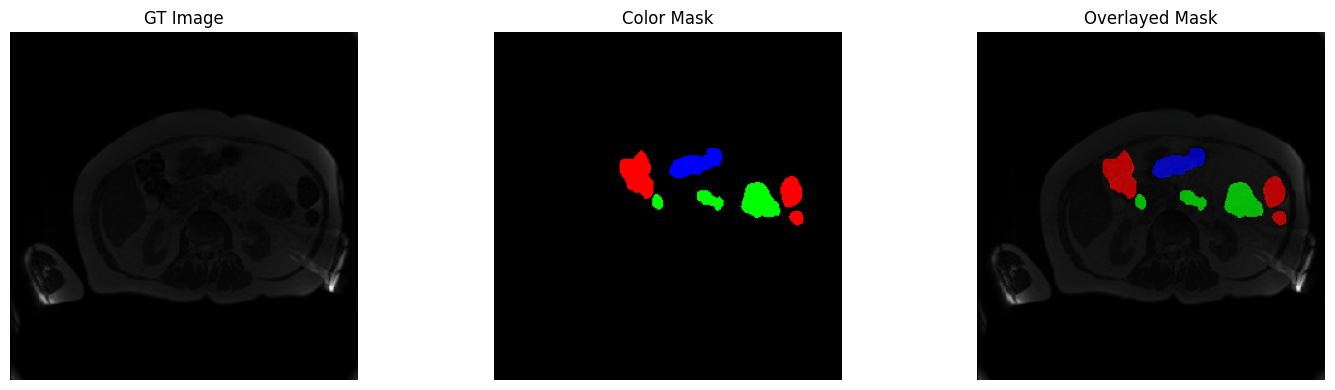

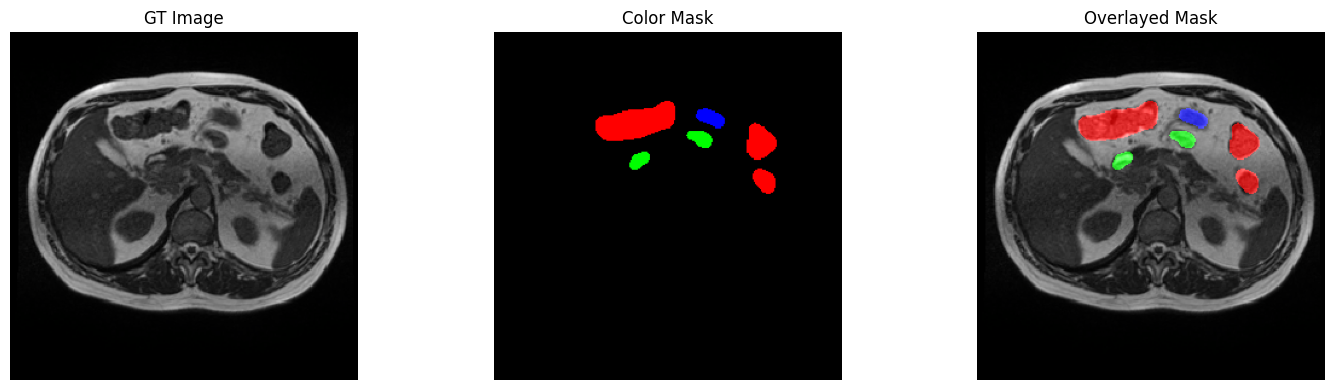

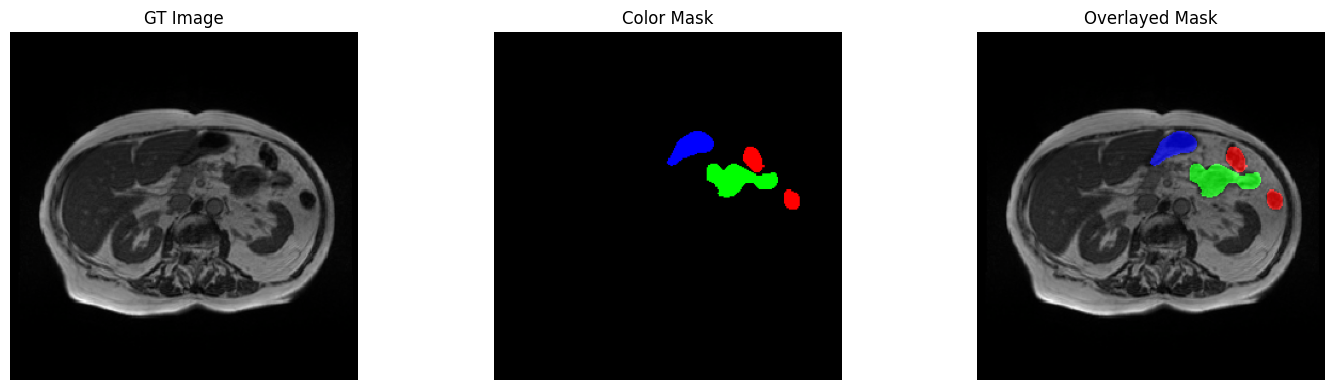

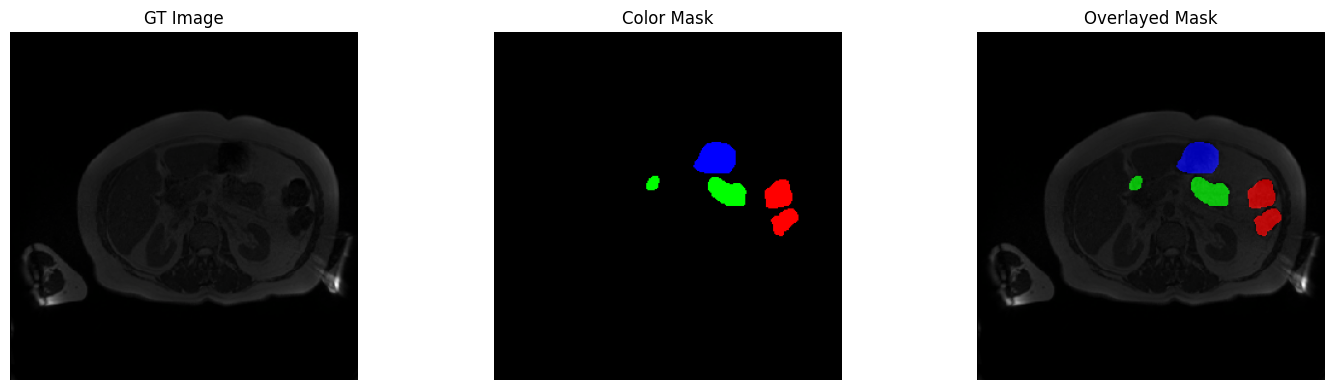

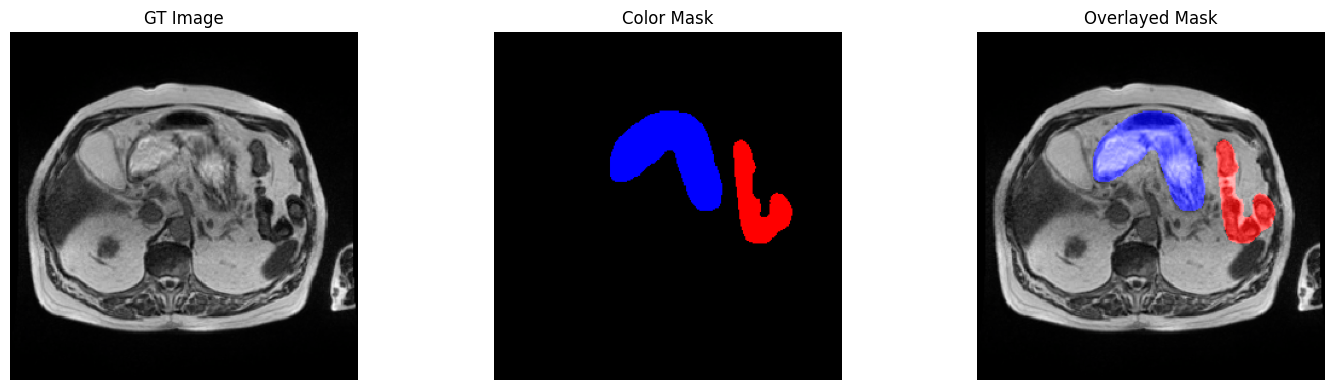

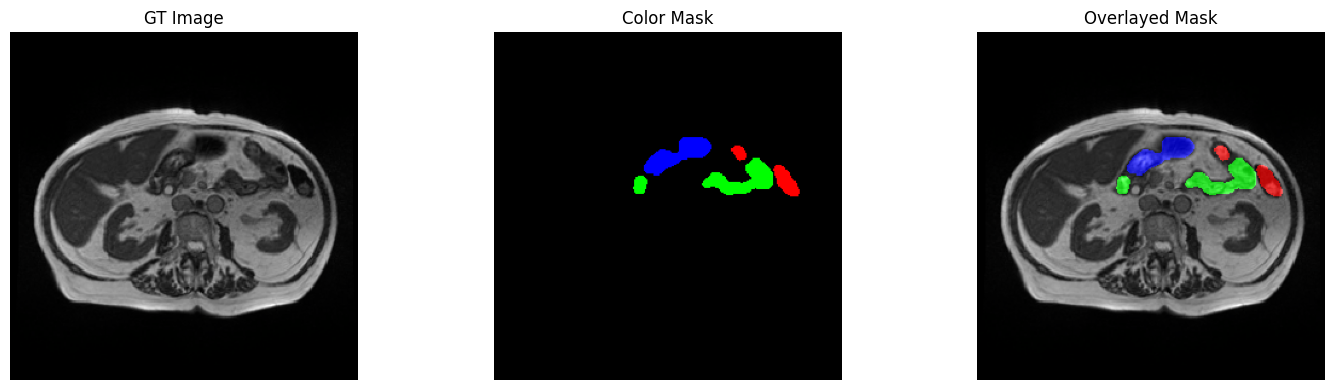

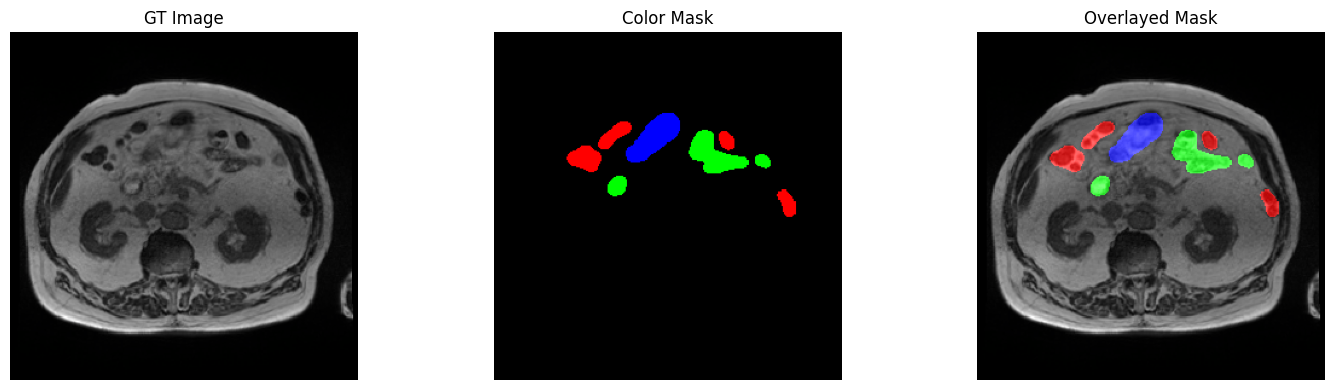

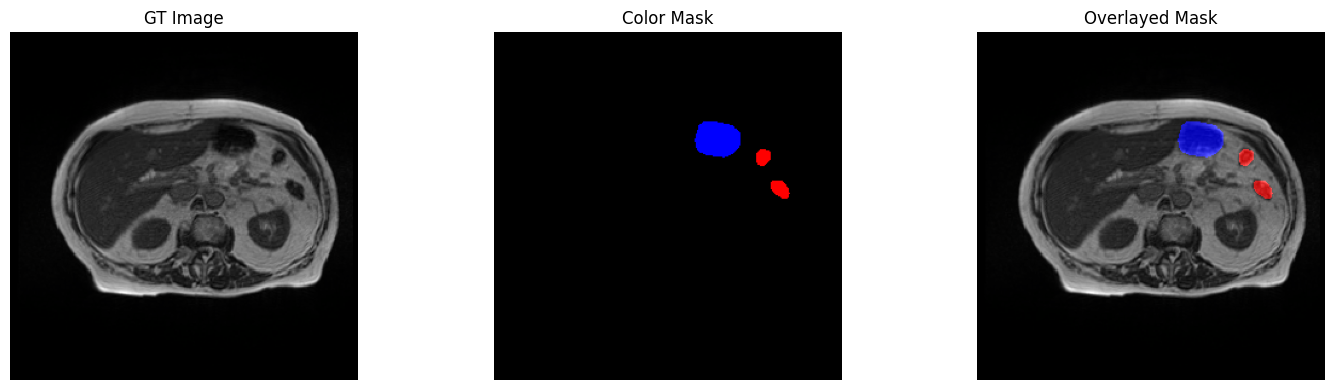

In [15]:
for batch_images, batch_masks in valid_loader:

    batch_images = denormalize(batch_images, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
    batch_masks  = batch_masks.numpy()

    print("batch_images shape:", batch_images.shape)
    print("batch_masks shape: ", batch_masks.shape)
    
    display_image_and_mask(images=batch_images, masks=batch_masks)

    break

## 4 Loading SegFormer From 🤗 HuggingFace

**You can check all the trained weights available for SegFormer model on HuggingFace <a href="https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads&search=nvidia%2Fsegformer" target="_blank">over here.</a>**

Loading a pre-trained model version and getting it ready for inference or finetuning is very easy, thanks to HuggingFace. We only have to pass the following:

1. `pretrained_model_name_or_path`: (string). The id/path of a pre-trained model hosted on the Huggingface model zoo.
2. `num_labels`: (int) The number of channels (one for each class) we want the model to give as output. Suppose the number differs from the original number. In that case, the layer will be replaced with a new layer with randomly initialized weights.
3. `ignore_mismatched_sizes`: (bool) Boolean value to whether or not to ignore the weight key mismatch. Here, it occurs because we change the `num_labels` value.  

In [16]:
def get_model(*, model_name, num_classes):
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
    )
    return model

**Usage**

In [17]:
# Define model
model = get_model(model_name=TrainingConfig.MODEL_NAME, num_classes=DatasetConfig.NUM_CLASSES)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


* The model's forward pass takes multiple arguments <a href="https://huggingface.co/docs/transformers/v4.15.0/model_doc/segformer#transformers.SegformerForSemanticSegmentation.forward" target="_blank">[SegFormer Documentation]</a>. The two important ones are `pixel_values` and `labels`.
* The `pixel_values` argument refers to the input images. The `labels` argument is for passing the ground-truth mask.  
* The model's forward pass also calculates the cross-entropy loss if `labels` are passed.
* The output logits are smaller than the input image size. To get the **outputs** to match the input image size, we need to simply **upsample** it.

In [18]:
# Create dummy inputs.
data    = torch.randn(1, 3, *DatasetConfig.IMAGE_SIZE[::-1])
target = torch.rand(1, *DatasetConfig.IMAGE_SIZE[::-1]).to(torch.long)

In [19]:
# Generate dummy outputs.
outputs = model(pixel_values=data, labels=target, return_dict=True)

# Upsample model outputs to match input image size.
upsampled_logits = nn.functional.interpolate(outputs["logits"], size=target.shape[-2:], mode="bilinear", align_corners=False)

To access the model's output, we have to use the `["logits"]` key. Similarly, we can access the loss via the `"loss"` key.

In [20]:
print("Model Outputs: outputs['logits']:", outputs["logits"].shape)

print("Model Outputs Resized::", upsampled_logits.shape)

print("Loss: outputs['loss']:", outputs["loss"])

Model Outputs: outputs['logits']: torch.Size([1, 4, 72, 72])
Model Outputs Resized:: torch.Size([1, 4, 288, 288])
Loss: outputs['loss']: tensor(1.4241, grad_fn=<NllLoss2DBackward0>)


In this project, we won’t be using the CE loss returned by the model for training. Instead, we will define our custom combo loss function that combines the Smooth Dice coefficient & CE to compute the loss.summary(model, input_size=(1, 3, *DatasetConfig.IMAGE_SIZE[::-1]), depth=2, device="cpu")


In [21]:
summary(model, input_size=(1, 3, *DatasetConfig.IMAGE_SIZE[::-1]), depth=2, device="cpu")

Layer (type:depth-idx)                                                      Output Shape              Param #
SegformerForSemanticSegmentation                                            [1, 4, 72, 72]            --
├─SegformerModel: 1-1                                                       [1, 64, 72, 72]           --
│    └─SegformerEncoder: 2-1                                                [1, 64, 72, 72]           60,842,688
├─SegformerDecodeHead: 1-2                                                  [1, 4, 72, 72]            --
│    └─ModuleList: 2-2                                                      --                        789,504
│    └─Conv2d: 2-3                                                          [1, 768, 72, 72]          2,359,296
│    └─BatchNorm2d: 2-4                                                     [1, 768, 72, 72]          1,536
│    └─ReLU: 2-5                                                            [1, 768, 72, 72]          --
│    └─Dropout: 2-6        

## 5 Evaluation Metric  & Loss Function

In [22]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)

    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)

    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()

    CE = F.cross_entropy(predictions, ground_truths)

    return (1.0 - dice_mean) + CE

### 5.2 Evaluation Metric - Dice Coefficient (F1-Score) 


To calculate the Dice score for the medical image segmentation task, we will use the `MulticlassF1Score` class from the `torchmetrics` library with the "`macro`" average reduction method.

**Macro** average refers to a method of calculating average performance in multiclass or multilabel classification problems, which treats all classes equally.

## 6 Creating The Custom LightningModule Class

The final custom class we need to create is the `MedicalSegmentationModel` which inherits its functionalities from Lightning’s `LightningModule` class.

The `LightningModule` class in pytorch-lightning is a higher-level abstraction that simplifies the training and organizing of PyTorch models. It provides a structured, standardized interface for defining and training deep learning models. It separates the concerns of model definition, optimization, and training loop, making the code more modular and readable.


The class methods we need to define are as follows:

1. Model initialization: `__init__(...)` method where the model and its parameters are defined. This method also includes the initialization of the loss and metric calculation methods.
2. Forward pass: `forward(...)` method where the forward pass of the model is defined.
Training step: training_step(...) method where the training step for each batch is defined. It includes calculating loss and metrics, which are logged for tracking.
3. Validation step: `validation_step(...)` method where the validation step for each batch is defined. It also includes the calculation of loss and metrics.
4. Optimizer configuration: `configure_optimizers(...)` method where the optimizer and, optionally, the learning rate scheduler are defined.

Moreover, two methods, `on_train_epoch_end(...)` and `on_validation_epoch_end(...)`, are defined to log the average loss and f1 score after each epoch for training and validation, respectively.

In [23]:
class MedicalSegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 10,
        init_lr: float = 0.001,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        scheduler_name: str = "multistep_lr",
        num_epochs: int = 100,
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(model_name=self.hparams.model_name, num_classes=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")

    def forward(self, data):
        outputs = self.model(pixel_values=data, return_dict=True)
        upsampled_logits = F.interpolate(outputs["logits"], size=data.shape[-2:], mode="bilinear", align_corners=False)
        return upsampled_logits
    
    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)

        # Calculate Combo loss (Segmentation specific loss (Dice) + cross entropy)
        loss = dice_coef_loss(logits, target, num_classes=self.hparams.num_classes)
        
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_f1(logits.detach(), target)

        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=False)
        self.log("train/batch_f1", self.mean_train_f1, prog_bar=True, logger=False)
        return loss

    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True)
        self.log("train/f1", self.mean_train_f1, prog_bar=True)
        self.log("epoch", self.current_epoch)

    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
        
        # Calculate Combo loss (Segmentation specific loss (Dice) + cross entropy)
        loss = dice_coef_loss(logits, target, num_classes=self.hparams.num_classes)

        self.mean_valid_loss.update(loss, weight=data.shape[0])
        self.mean_valid_f1.update(logits, target)

    def on_validation_epoch_end(self):
        
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid/f1", self.mean_valid_f1, prog_bar=True)
        self.log("epoch", self.current_epoch)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer_name)(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.hparams.init_lr,
            weight_decay=self.hparams.weight_decay,
        )

        LR = self.hparams.init_lr
        WD = self.hparams.weight_decay

        if self.hparams.optimizer_name in ("AdamW", "Adam"):
            optimizer = getattr(torch.optim, self.hparams.optimizer_name)(model.parameters(), lr=LR, 
                                                                          weight_decay=WD, amsgrad=True)
        else:
            optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=WD)

        if self.hparams.use_scheduler:
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[self.trainer.max_epochs // 2,], gamma=0.1)

            # The lr_scheduler_config is a dictionary that contains the scheduler
            # and its associated configuration.
            lr_scheduler_config = {"scheduler": lr_scheduler, "interval": "epoch", "name": "multi_step_lr"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

        else:
            return optimizer

## 7 Start Training

Once we have organized the `LightningModule` and `LightningDataModule` classes, we can utilize Lightning's `Trainer` class to automate the remaining tasks effortlessly.

The `Trainer` offers a range of valuable deep-learning training functionalities, such as mixed-precision training, distributed training, deterministic training, profiling, gradient accumulation, batch overfitting, and more. Implementing these functionalities correctly can be time-consuming, but it becomes a swift process with the `Trainer` class.

By initializing our `MedicalSegmentationModel` and `MedicalSegmentationDataModule` classes and passing them to the `.fit(...)` method of the `Trainer` class instance, we can promptly commence training. This streamlined approach eliminates the need to implement various training aspects manually, providing convenience and efficiency.

In [24]:
# Seed everything for reproducibility.
pl.seed_everything(42, workers=True)

model = MedicalSegmentationModel(
    model_name=TrainingConfig.MODEL_NAME,
    num_classes=DatasetConfig.NUM_CLASSES,
    init_lr=TrainingConfig.INIT_LR,
    optimizer_name=TrainingConfig.OPTIMIZER_NAME,
    weight_decay=TrainingConfig.WEIGHT_DECAY,
    use_scheduler=TrainingConfig.USE_SCHEDULER,
    scheduler_name=TrainingConfig.SCHEDULER,
    num_epochs=TrainingConfig.NUM_EPOCHS,
)

data_module = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

Seed set to 42
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, we will define a `ModelCheckpoint` and a `LearningRateMonitor` callback for saving the best model during training and the current learning rate of an epoch.

**NOTE**: The original notebook utilized the validation dataset both for 1) making decisions on the best model during training and 2) for inference. However, inference should ideally be conducted on unseen samples. In our approach, the validation dataset will still be utilized during training and inference, but its results on F1 score and loss function **will not** be considered for selecting the best model. Instead, the best model will be determined based on the training F1 score. Additionally, we will save the model corresponding to the last checkpoint.

In [25]:
# Creating ModelCheckpoint callback. 
# We'll save the model on basis on training f1-score.
#model_checkpoint = ModelCheckpoint(
#    monitor="valid/f1",
#    mode="max",
#    save_last=True,
#    filename="ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}",
#    auto_insert_metric_name=False,
#)

model_checkpoint = ModelCheckpoint(
    monitor="train/f1",
    mode="max",
    save_last=True,
    filename="ckpt_{epoch:03d}-vloss_{train/loss:.4f}_vf1_{train/f1:.4f}",
    auto_insert_metric_name=False,
)

# Creating a learning rate monitor callback which will be plotted/added in the default logger.
lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")

We will also initialize the `WandbLogger` to upload the training metrics to your wandb project.
 
During the logger initialization, we set two parameters:
1. `log_model=True` - Upload the model as an artifact when the training is completed.
2. `project` - The project name to use on WandB. A project typically contains logs from multiple experiments and their checkpoints.

In [26]:
# Initialize logger.
wandb_logger = WandbLogger(log_model=True, project="UM_medical_segmentation")

When the logger is initialized, it will also print the link for the current experiment, which you open on any device to monitor the training process and also share with your team.

**Train**

In [ ]:
# Initializing the Trainer class object.
trainer = pl.Trainer(
    accelerator="auto",  # Auto select the best hardware accelerator available
    devices="auto",  # Auto select available devices for the accelerator (For eg. mutiple GPUs)
    strategy="auto",  # Auto select the distributed training strategy.
    max_epochs=TrainingConfig.NUM_EPOCHS,  # Maximum number of epoch to train for.
    enable_model_summary=False,  # Disable printing of model summary as we are using torchinfo.
    callbacks=[model_checkpoint, lr_rate_monitor],  # Declaring callbacks to use.
    precision="16-mixed",  # Using Mixed Precision training.
    logger=wandb_logger
)

# Start training
trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  13%|█▎        | 115/865 [1:01:12<6:39:08,  0.03it/s, v_num=cmzv, train/batch_loss=0.730, train/batch_f1=0.442]

## 8 Inference on the Medical Segmentation Dataset

For inference, we will use the validation data. We will plot the ground truth images, the ground truth masks, and the predicted segmentation maps overlayed on the ground truth images.

### 8.1 Load The Best Trained Model

In [ ]:
# Get the path of the best saved model.
CKPT_PATH = model_checkpoint.best_model_path
CKPT_PATH

Initialize the model with trained weights.

In [ ]:
model = MedicalSegmentationModel.load_from_checkpoint(CKPT_PATH)

### 8.2 Evaluate Model On Validation Dataset

In [ ]:
# Get the validation dataloader.

data_module.setup()
valid_loader = data_module.val_dataloader()

Get the best evaluation metrics using the saved model.

In [ ]:
# Initialize trainer class for inference.
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,        
    enable_checkpointing=False,
    inference_mode=True,
)

# Run evaluation.
results = trainer.validate(model=model, dataloaders=valid_loader)

Log them as experiment summary metrics to WandB.

In [ ]:
if os.environ.get("LOCAL_RANK", None) is None:
    wandb.run.summary["best_valid_f1"] = results[0]["valid/f1"]
    wandb.run.summary["best_valid_loss"] = results[0]["valid/loss"]

### 8.3 Image Inference Using DataLoader Objects

In the code below, we define a helper function  that performs `inference` given a trained model and a dataloader object. The model prediction will also be uploaded to wandb.

In [ ]:
@torch.inference_mode()
def inference(model, loader, img_size, device="cpu"):
    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, (batch_img, batch_mask) in enumerate(loader):
        predictions = model(batch_img.to(device))

        pred_all = predictions.argmax(dim=1).cpu().numpy()

        batch_img = denormalize(batch_img.cpu(), mean=DatasetConfig.MEAN, std=DatasetConfig.STD)
        batch_img = batch_img.permute(0, 2, 3, 1).numpy()

        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):
            fig = plt.figure(figsize=(20, 8))

            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text("Actual frame")
            plt.axis("off")

            # Display the ground truth mask.
            true_mask_rgb = num_to_rgb(batch_mask[i], color_map=id2color)
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth labels")
            ax2.imshow(true_mask_rgb)
            plt.axis("off")

            # Display the predicted segmentation mask.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color)
            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Predicted labels")
            ax3.imshow(pred_mask_rgb)
            plt.axis("off")

            # Display the predicted segmentation mask overlayed on the original image.
            overlayed_image = image_overlay(batch_img[i], pred_mask_rgb)
            ax4 = fig.add_subplot(1, 4, 4)
            ax4.set_title("Overlayed image")
            ax4.imshow(overlayed_image)
            plt.axis("off")
            plt.show()
            
            # Upload predictions to WandB.
            images = wandb.Image(fig, caption=f"Prediction Sample {idx}_{i}")
            
            if os.environ.get("LOCAL_RANK", None) is None:
                wandb.log({"Predictions": images})

In [ ]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(DEVICE)
model.eval()

inference(model, valid_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE)

Terminate the wandb experiment run.

In [ ]:
if os.environ.get("LOCAL_RANK", None) is None:
    wandb.run.finish()